In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data 
from torchvision import transforms
from torchvision.datasets import CIFAR10
import time

In [2]:
device = torch.device("cuda:3")
cpu = torch.device("cpu")

In [3]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机翻转，数据增强 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [4]:
trainset = CIFAR10(
    root="./data/CIFAR10",
    train=True,
    download=True,
    transform=transforms_train
)

testset = CIFAR10(
    root="./data/CIFAR10",
    train=False,
    download=True,
    transform=transforms_test
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [5]:
trainsetAE1, trainsetAE2, trainsetAE3, trainsetAE4, trainsetAE5 = torch.utils.data.random_split(
    trainset, [10000, 10000, 10000, 10000, 10000])

In [38]:
trainloader = torch.utils.data.DataLoader(
    dataset=trainsetAE1,
    batch_size=256,
    shuffle=True,
)

testloader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=256,
    shuffle=False
)

In [39]:
class EnDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.GELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, 2*32, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            nn.GELU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*32, 384) # 特征向量压缩到384维
        )
        
        self.linear = nn.Sequential(
            nn.Linear(384, 2*16*32),
            nn.GELU()
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(2*32, 2*32, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2*32, 32, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.Encoder(x)
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.Decoder(x)
        return x

In [40]:
model = EnDecoder()
criterion = nn.MSELoss(reduction="none")
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device)
criterion = criterion.to(device)

In [41]:
N_epoch = 500
for epoch in range(N_epoch):
    print("epoch = %d in %d" % (epoch, N_epoch))
    time_start = time.process_time()
    
    for x, _ in trainloader:
        x = x.to(device)
        x_ = model(x)
        loss = criterion(x, x_)
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #print("Time elapsed = ", time.process_time()-time_start)
    print("Loss = ", loss.item())

epoch = 0 in 500
Loss =  1950.7095947265625
epoch = 1 in 500
Loss =  1900.3985595703125
epoch = 2 in 500
Loss =  1781.1689453125
epoch = 3 in 500
Loss =  1381.453857421875
epoch = 4 in 500
Loss =  1461.385009765625
epoch = 5 in 500
Loss =  1134.132080078125
epoch = 6 in 500
Loss =  1365.958740234375
epoch = 7 in 500
Loss =  1054.4224853515625
epoch = 8 in 500
Loss =  1465.2568359375
epoch = 9 in 500
Loss =  1262.9385986328125
epoch = 10 in 500
Loss =  1235.3212890625
epoch = 11 in 500
Loss =  1266.8223876953125
epoch = 12 in 500
Loss =  1028.0592041015625
epoch = 13 in 500
Loss =  1090.3173828125
epoch = 14 in 500
Loss =  928.6561279296875
epoch = 15 in 500
Loss =  1041.2099609375
epoch = 16 in 500
Loss =  720.9102783203125
epoch = 17 in 500
Loss =  1212.8984375
epoch = 18 in 500
Loss =  1012.3008422851562
epoch = 19 in 500
Loss =  1077.1517333984375
epoch = 20 in 500
Loss =  867.2294921875
epoch = 21 in 500
Loss =  1308.678955078125
epoch = 22 in 500
Loss =  808.3228759765625
epoch = 

In [42]:
torch.save(model, 'AEmodels/AE5.pt')
test_model = torch.load('AEmodels/AE5.pt', map_location=device)

In [43]:
import torchvision
import matplotlib.pyplot as plt

In [44]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def get_train_images(num):
    return torch.stack([testset[200*i][0] for i in range(num)], dim=0)

/home/zhuomengzhang/.conda/envs/torch/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


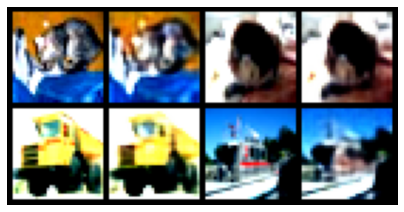

In [45]:
input_imgs = get_train_images(4)
visualize_reconstructions(test_model, input_imgs)